<a href="https://colab.research.google.com/github/shaoyinguo-portfolio/warpage-pca/blob/main/PackageWarpagePCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warpage Analysis Using Principal Component Analysis

In the semiconductor packaging and Printed Circuit Board Assembly (PCBA) industries, **warpage control is critical to manufacturing yield and reliability.** Excessive warpage can lead to various defects, including opens, shorts, and adhesive delamination.

Conventional warpage analysis typically relies on simple surface flatness characterization methods, often measured as the total indicator reading (TIR)—the difference between maximum and minimum height values ($\text{Max height} - \text{Min height}$). This scalar approach provides a single aggregate value, which is often **inadequate for attributing complex warpage profiles to specific, underlying process factors.** It fails to capture the spatial characteristics and dominant shapes of the deformation.

**Principal Component Analysis (PCA) offers a powerful alternative** by providing a robust framework for spatial decomposition and dimensionality reduction. PCA transforms the complex, high-dimensional surface topography data into a set of orthogonal basis vectors, known as "eigen shapes" or principal components.

This methodology effectively preserves the most significant deformation shapes of the packages, which often directly correlate with specific process factors. PCA finds multiple advanced use cases in both technology development and High-Volume Manufacturing (HVM):

*   **Eigen Shape Magnitude Evolution:** Tracking the evolution of dominant warpage shapes across sequential manufacturing process operations (e.g., molding, reflow, die attach, lid/stiffener attach).
*   **Supplier Quality Management:** Investigating and addressing substrate supplier transparency issues related to incoming material quality and inherent warpage profiles.
*   **Localized Feature Correlation:** Correlating specific local substrate undulations or features with yield outcomes.
*   **HVM Statistical Process Control (SPC):** Implementing advanced SPC monitoring for key principal components to detect process drifts.
*   **Anomaly Detection:** Identifying subtle anomalies, such as those indicative of latent adhesive delamination or unexpected material behaviors.
*   **Tooling Health Monitoring:** Detecting consistent deformation patterns indicative of tooling wear-and-tear or fixture misalignment.

This demo project will illustrate how PCA can be applied to warpage data to uncover insights that conventional methods miss.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

np.random.seed(42)

# helper class for synthetic data generation and plotting:

class WarpageDataGenerator:
    def __init__(self, form_factor=(20,20,5)):
        x = np.linspace(-form_factor[0]/2, form_factor[0]/2, form_factor[0]*form_factor[2])
        y = np.linspace(-form_factor[1]/2, form_factor[1]/2, form_factor[1]*form_factor[2])
        self.X, self.Y = np.meshgrid(x, y)

    def polynomial_surface(self, coeffs_dict, degree, plot=False):
        """Calculates Z values for a given set of coefficients and degree."""
        Z = np.zeros_like(self.X)
        for i in range(degree + 1):
            for j in range(degree + 1 - i):
                key = f'a{i}{j}'
                if key in coeffs_dict:
                    Z += coeffs_dict[key] * (self.X**i) * (self.Y**j)
        Z = Z - np.mean(Z)
        Z = Z / np.sqrt(np.sum(Z**2)) # unit vector

        if plot:
            fig = plt.figure(figsize=(2,2))
            plt.imshow(Z, cmap='jet', origin='lower')
            plt.colorbar()
            plt.axis('off')
            plt.show()
        return Z

    def gaussian_surface(self, amplitude, xo, yo, ax, ay, theta=0, offset=0, plot=False):
        """2-D Gaussian surface"""
        xo = float(xo)
        yo = float(yo)
        xx = np.cos(theta)*(self.X-xo) + np.sin(theta)*(self.Y-yo)
        yy = -(np.sin(theta)*(self.X-xo)) + np.cos(theta)*(self.Y-yo)
        Z = offset + amplitude*np.exp( - ((xx**2/2/ax**2) + (yy**2/2/ay**2)))

        if plot:
            fig = plt.figure(figsize=(2,2))
            plt.imshow(Z, cmap='jet', origin='lower')
            plt.colorbar()
            plt.axis('off')
            plt.show()
        return Z

    def generate_warpage(self, mu, mean_and_std, noise, plot=True):
        warpage = 0
        for mu_i, (mean, std) in zip(mu, mean_and_std):
            warpage += np.random.normal(mean, std) * mu_i
        warpage += np.random.normal(0, noise, warpage.shape)

        if plot:
            fig = plt.figure(figsize=(2,2))
            plt.imshow(warpage, cmap='jet', origin='lower')
            plt.colorbar()
            plt.axis('off')
            plt.show()
        return warpage

    def generate_dataset(self, mu, mean_and_std, n_samples, noise):
        data = []
        for i in range(n_samples):
            data.append(self.generate_warpage(mu, mean_and_std, 1, False).flatten())
        return np.array(data)

    def plot_warpage(self, data, n_cols=10):
        n_plots = data.shape[0]
        n_rows = int(np.ceil( n_plots / n_cols))
        vmin, vmax = np.min(data), np.max(data)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols,2*n_rows))
        axs = axs.flatten()
        for i in range(axs.shape[0]):
            ax = axs[i]
            ax.axis('off')
            ax.set_aspect('equal')
            if i < n_plots:
                ax.scatter(self.X.flatten(), self.Y.flatten(), c=data[i], cmap='jet', s=1, vmin=vmin, vmax=vmax)
                ax.set_title(f'{i}')
        plt.tight_layout()
        plt.show()

## Synthetic Data Generation

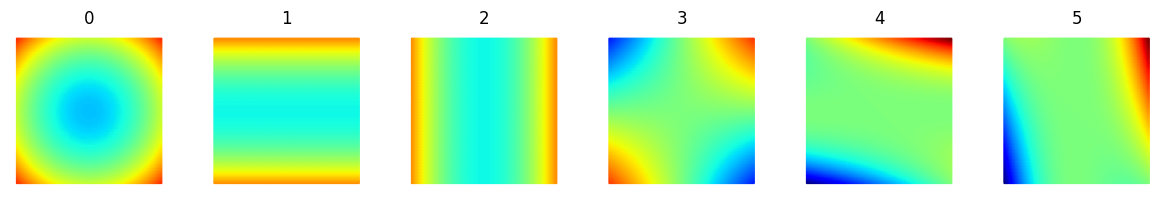

In [2]:
np.random.seed(42) # for reproducibility

gen = WarpageDataGenerator((20,20,5))

# generating eigen vectors
mu_bow = gen.polynomial_surface({'a00': 0, 'a20': 1, 'a02': 1}, 2, plot=False)
mu_ux = gen.polynomial_surface({'a00': 0, 'a02': 1}, 2, plot=False)
mu_uy = gen.polynomial_surface({'a00': 0, 'a20': 1}, 2, plot=False)
mu_x = gen.polynomial_surface({'a00': 0, 'a11': 1}, 2, plot=False)
mu_sx = gen.polynomial_surface({'a00': 0, 'a03': 1, 'a12':1}, 3, plot=False)
mu_sy = gen.polynomial_surface({'a00': 0, 'a30': 1, 'a21':1}, 3, plot=False)

mu = [mu_bow, mu_ux, mu_uy, mu_x, mu_sx, mu_sy]

# mean and std of each eigen mode
mean_and_std = [(1000, 300), (1000,100), (1000,70), (0,500), (0, 50), (0, 10)]

baseline = gen.generate_dataset(mu, mean_and_std, 1000, 1)

new_data = gen.generate_dataset(mu, mean_and_std, 200, 1)

# adding local defects to new data
defect_index = sorted(np.random.randint(0, new_data.shape[0], 10).tolist())

for idx in defect_index:
    new_data[idx] = new_data[idx] + gen.gaussian_surface(5, 5, 5, 1, 1, plot=False).flatten()

gen.plot_warpage(np.array(mu), n_cols=len(mu))

## EDA

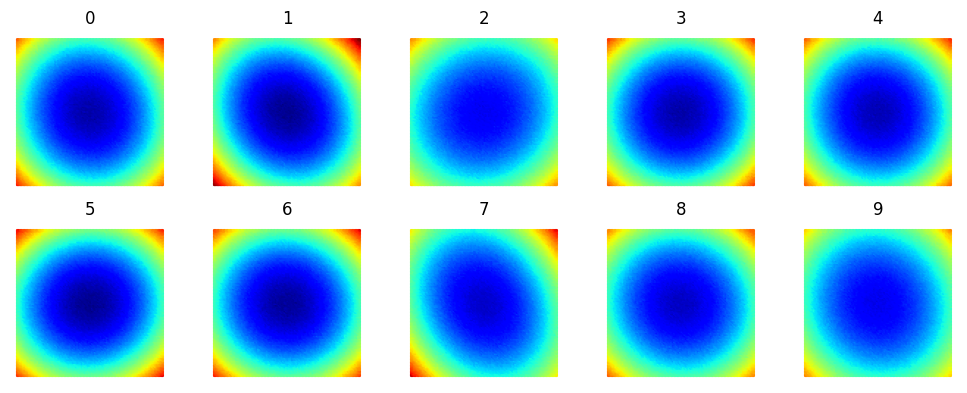

In [13]:
gen.plot_warpage(new_data[0:10], n_cols=5)


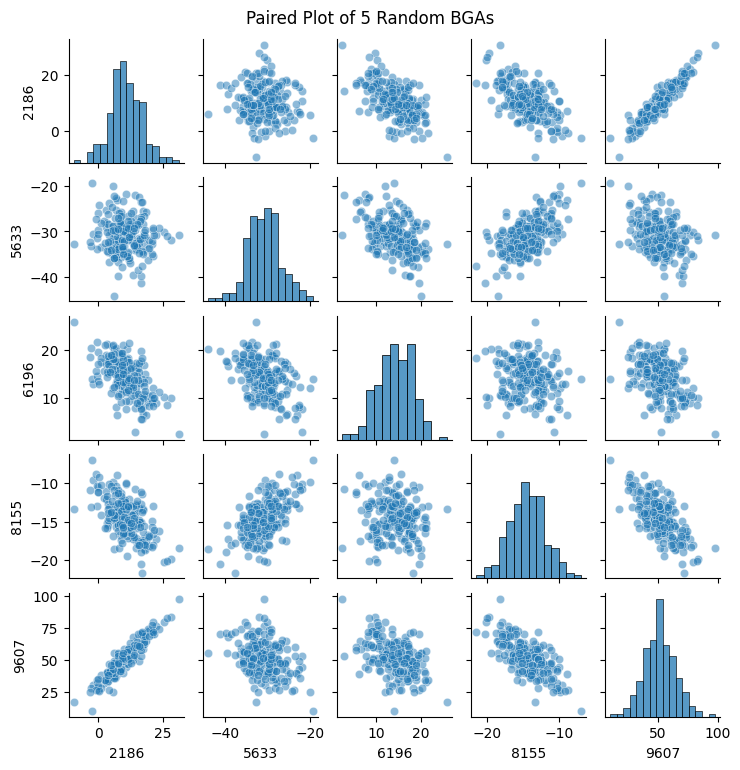

In [22]:
rand_index = sorted(np.random.randint(0, new_data.shape[1], 5).tolist())

g = sns.pairplot(pd.DataFrame(new_data), x_vars=rand_index, y_vars=rand_index, height=1.5, plot_kws={'alpha': 0.5})
g.fig.suptitle('Paired Plot of 5 Random BGAs', y=1.02)
plt.show()

##Algorithm - PCA

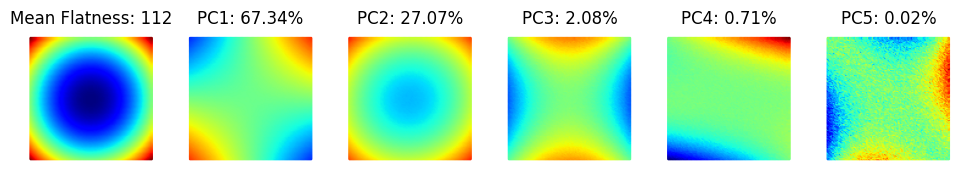

In [5]:
pca = PCA(n_components=5)
base_line_reduced = pca.fit_transform(baseline)

# plot mean and principle components (aka eigen shapes)
n_plots = pca.components_.shape[0]+1
fig = plt.figure(figsize=(2*n_plots,2))
ax = plt.subplot(1, n_plots, 1)
ax.set_aspect('equal')
plt.scatter(gen.X.flatten(), gen.Y.flatten(), c=pca.mean_, cmap='jet', s=1)
plt.axis('off')
plt.title(f'Mean Flatness: {int(max(pca.mean_) - min(pca.mean_))}')
vmin, vmax = np.min(pca.components_), np.max(pca.components_)
for i in range(pca.components_.shape[0]):
    ax = plt.subplot(1, n_plots, i+2)
    ax.set_aspect('equal')
    plt.scatter(gen.X.flatten(), gen.Y.flatten(), c=pca.components_[i], cmap='jet', s=1, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title(f'PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}%')
plt.show()


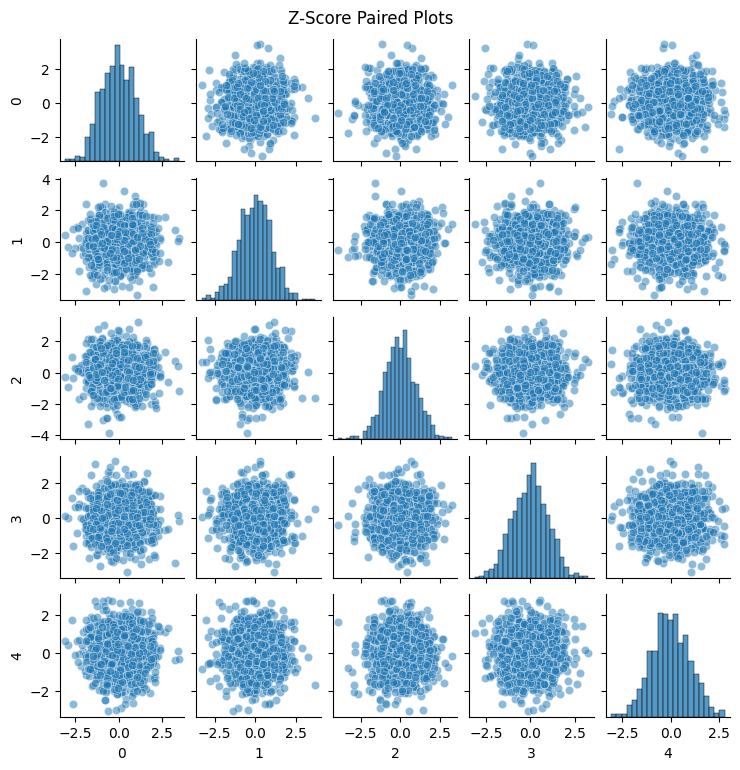

In [23]:
g = sns.pairplot(pd.DataFrame(base_line_reduced / np.sqrt(pca.explained_variance_)), height=1.5, plot_kws={'alpha': 0.5})
g.fig.suptitle('Z-Score Paired Plots', y=1.02)
plt.show()

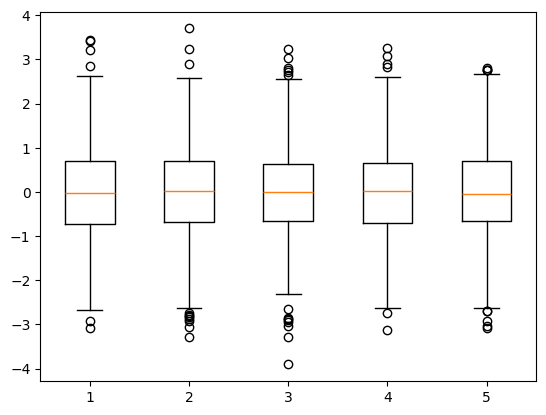

In [7]:
a = plt.boxplot(base_line_reduced / np.sqrt(pca.explained_variance_))

In [8]:
new_data_reduced = pca.transform(new_data)
new_data_residual = new_data - pca.inverse_transform(new_data_reduced)

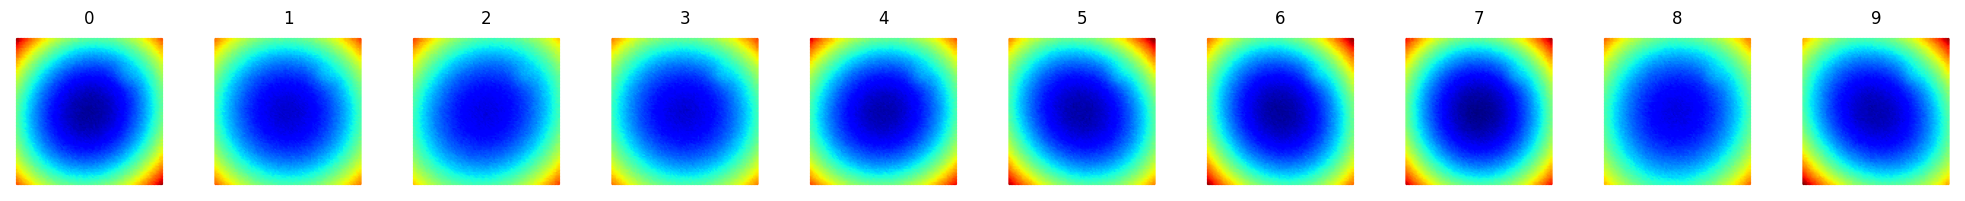

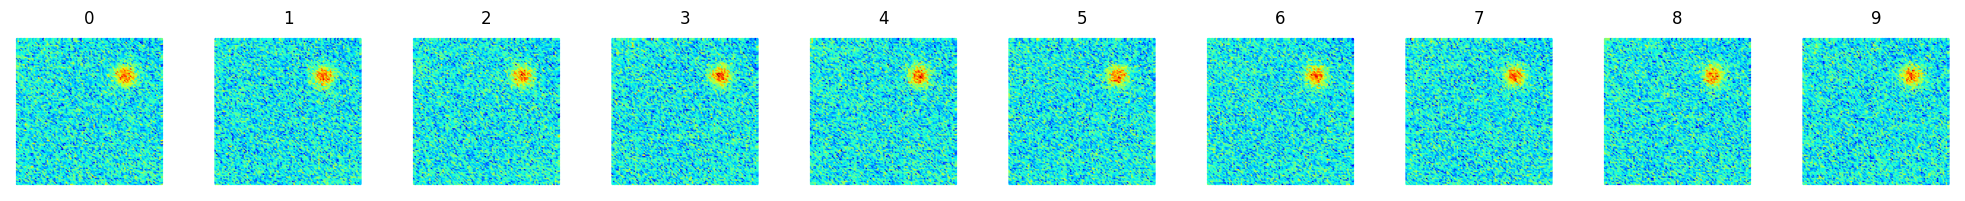

In [9]:
gen.plot_warpage(new_data[defect_index])
gen.plot_warpage(new_data_residual[defect_index])

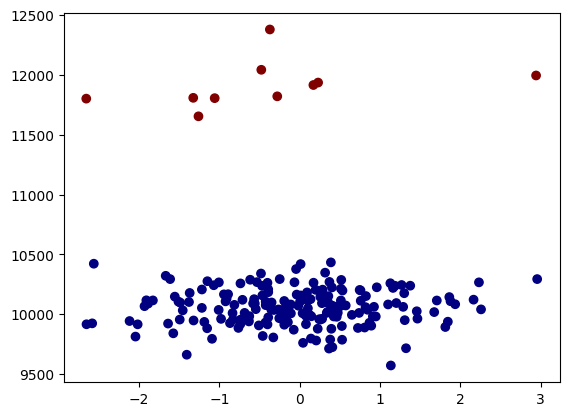

In [10]:
c = np.zeros(new_data.shape[0])
c[defect_index] = 1
plt.scatter(np.random.randn(new_data.shape[0]), np.sum(new_data_residual**2, axis=1), c=c, cmap='jet')